# YOLOv5 Model with Robinson Compass Edge Detection

In [1]:
import os
import numpy as np
import cv2
import torch
import yaml
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from PIL import Image
import json
import shutil

## Robinson Compass Mask

In [2]:
def create_robinson_compass_masks():
    """
    Create Robinson Compass masks for all 8 directions (N, NE, E, SE, S, SW, W, NW)
    Robinson masks use combinations of 0, 1, and 2 values for directional edge detection
    """
    robinson_masks = {
        'North': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
        'North-East': np.array([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]]),
        'East': np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]),
        'South-East': np.array([[2, 1, 0], [1, 0, -1], [0, -1, -2]]),
        'South': np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]),
        'South-West': np.array([[0, -1, -2], [1, 0, -1], [2, 1, 0]]),
        'West': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
        'North-West': np.array([[-2, -1, 0], [-1, 0, 1], [0, 1, 2]])
    }
    
    return robinson_masks

In [3]:
def apply_robinson_edge_detection(image, masks):
    """
    Apply all Robinson Compass masks to an image and combine the results
    
    Args:
        image: Grayscale input image
        masks: Dictionary of Robinson Compass masks
        
    Returns:
        combined_edges: Combined edge detection result
        direction_responses: Dictionary of edge responses in each direction
    """
    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
        
    combined_edges = np.zeros_like(gray_image, dtype=np.float32)
    direction_responses = {}
    
    # Apply each compass mask
    for direction, mask in masks.items():
        response = cv2.filter2D(gray_image, cv2.CV_32F, mask)
        response_abs = np.abs(response)
        direction_responses[direction] = response_abs
        combined_edges = np.maximum(combined_edges, response_abs)
    
    combined_edges = cv2.normalize(combined_edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return combined_edges, direction_responses

In [4]:
def apply_edge_detection_to_dataset(image_paths, num_samples=5, output_dir="edge_detection_results"):
    """
    Apply Robinson Compass edge detection to a sample of images from the dataset
    and save the results
    
    Args:
        image_paths: List of image paths
        num_samples: Number of random samples to process
        output_dir: Directory to save the results
    """
    os.makedirs(output_dir, exist_ok=True)
    
    robinson_masks = create_robinson_compass_masks()
    
    if len(image_paths) > num_samples:
        sample_paths = random.sample(image_paths, num_samples)
    else:
        sample_paths = image_paths
    
    results = []
    
    for img_path in tqdm(sample_paths, desc="Processing images"):
        # Read image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue
            
        # Apply Robinson edge detection
        edges, _ = apply_robinson_edge_detection(image, robinson_masks)
        
        # Save the result and original for comparison
        base_name = os.path.basename(img_path)
        output_path = os.path.join(output_dir, f"edge_{base_name}")
        cv2.imwrite(output_path, edges)
        
        # Store results for later visualization
        results.append({
            'original_path': img_path,
            'edge_path': output_path,
            'original': image,
            'edges': edges
        })
        
    return results

In [5]:
def visualize_edge_detection_results(results):
    """
    Visualize edge detection results side by side with original images
    
    Args:
        results: List of dictionaries containing original and edge-detected images
    """
    num_results = len(results)
    if num_results == 0:
        print("No results to visualize")
        return
        
    fig, axes = plt.subplots(num_results, 2, figsize=(12, 4 * num_results))
    
    if num_results == 1:
        axes = [axes]
        
    for i, result in enumerate(results):
        # Display original image
        axes[i][0].imshow(cv2.cvtColor(result['original'], cv2.COLOR_BGR2RGB))
        axes[i][0].set_title(f"Original Image")
        axes[i][0].axis('off')
        
        # Display edge detection result
        axes[i][1].imshow(result['edges'], cmap='gray')
        axes[i][1].set_title(f"Robinson Compass Edge Detection")
        axes[i][1].axis('off')
    
    plt.tight_layout()
    plt.savefig('robinson_edge_detection_comparison.png', dpi=300)
    plt.show()

In [6]:
def visualize_directional_responses(image_path):
    """
    Visualize edge detection in each of the 8 compass directions
    
    Args:
        image_path: Path to the image to process
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return
    
    robinson_masks = create_robinson_compass_masks()
    
    _, direction_responses = apply_robinson_edge_detection(image, robinson_masks)
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    # Display original image in the center
    axes[1][1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[1][1].set_title("Original Image")
    axes[1][1].axis('off')
    
    # Define positions for each direction in the 3x3 grid
    positions = {
        'North-West': (0, 0),
        'North': (0, 1),
        'North-East': (0, 2),
        'West': (1, 0),
        # Center position (1,1) is for the original image
        'East': (1, 2),
        'South-West': (2, 0),
        'South': (2, 1),
        'South-East': (2, 2)
    }
    
    for direction, pos in positions.items():
        if direction in direction_responses:
            axes[pos[0]][pos[1]].imshow(direction_responses[direction], cmap='hot')
            axes[pos[0]][pos[1]].set_title(direction)
            axes[pos[0]][pos[1]].axis('off')
    
    plt.tight_layout()
    plt.savefig('robinson_directional_responses.png', dpi=300)
    plt.show()

In [7]:
dataset_split = 'train'  # or 'valid'
image_dir = f'./SARscope/{dataset_split}'

# Get all image paths (excluding annotation files)
all_image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) 
    if fname.endswith(('.jpg', '.jpeg', '.png')) and not fname.startswith('_')]

# Apply edge detection to a sample of images
results = apply_edge_detection_to_dataset(all_image_paths, num_samples=5)

Processing images: 100%|██████████| 5/5 [00:00<00:00, 33.29it/s]


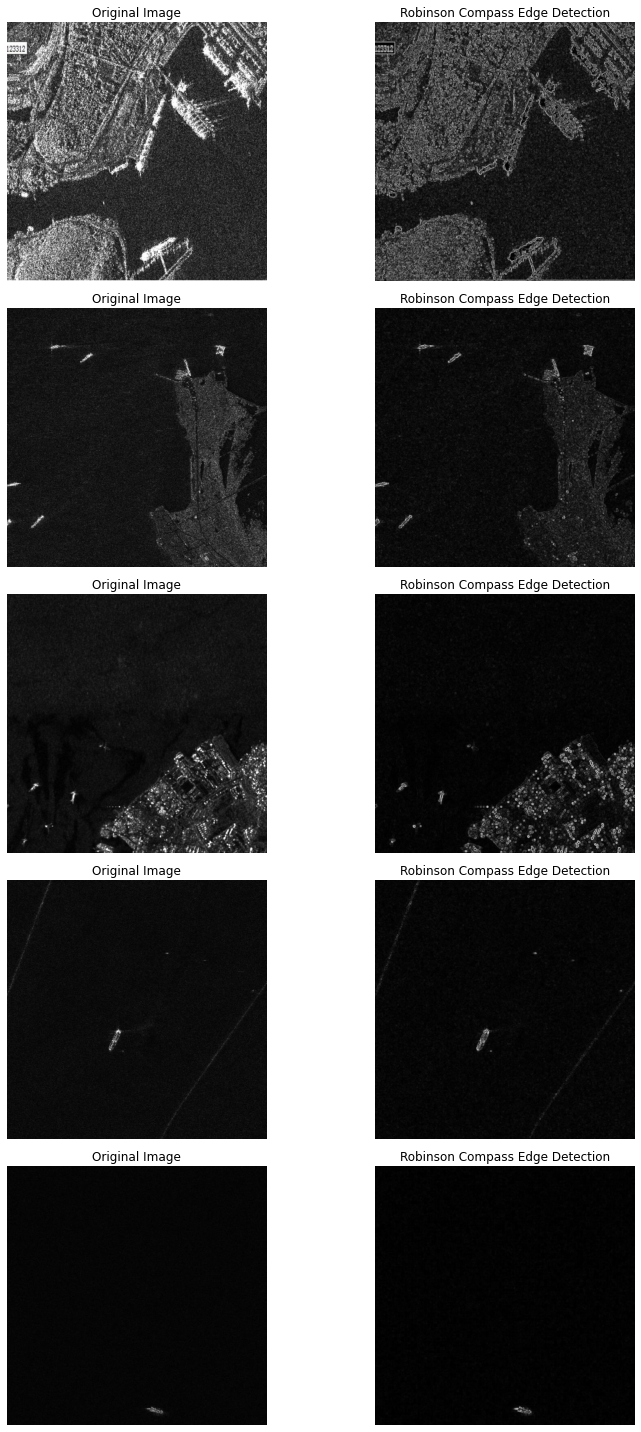

In [8]:
visualize_edge_detection_results(results)

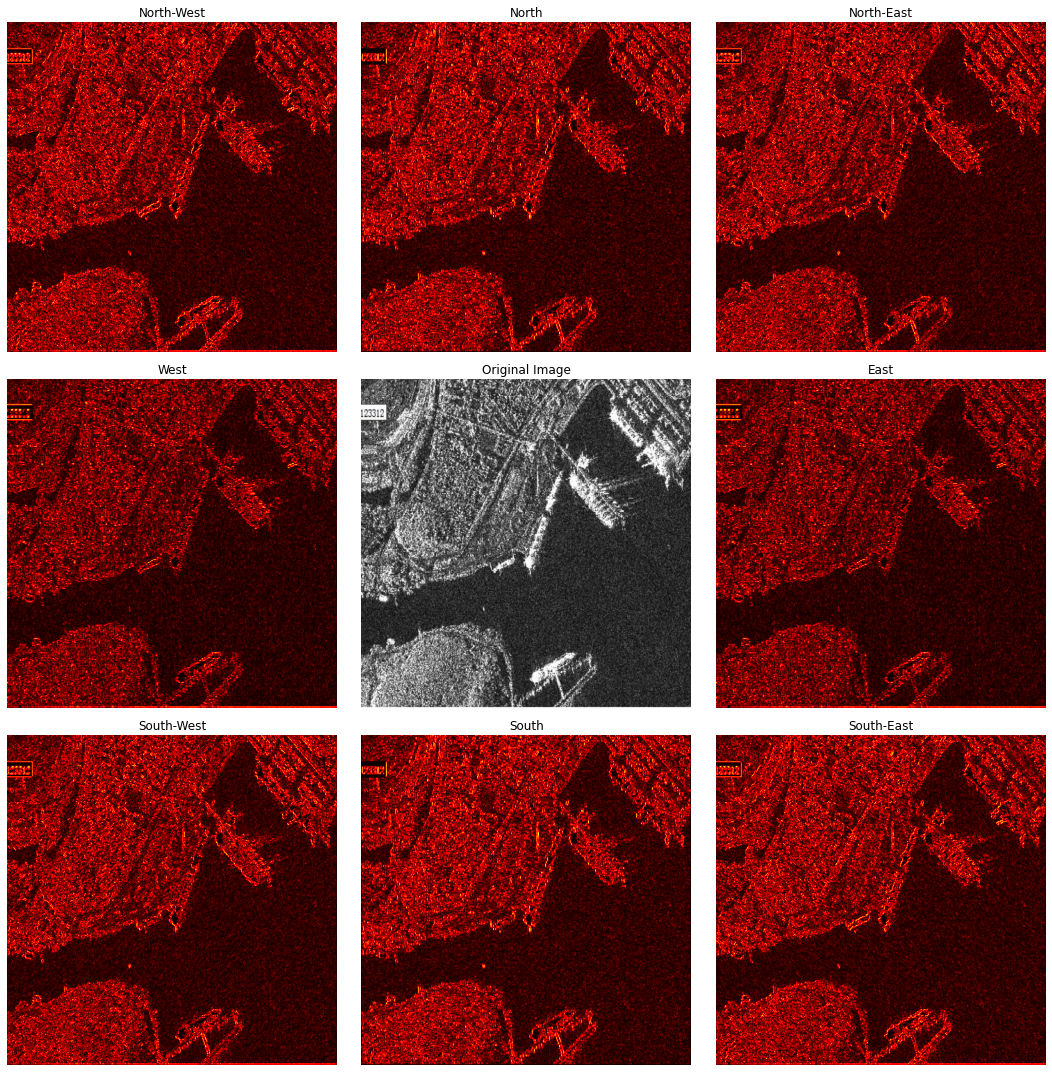

In [9]:
if results:
        visualize_directional_responses(results[0]['original_path'])

## Data Preparation

In [10]:
def prepare_edge_enhanced_dataset(original_dataset_dir, output_dir, edge_weight=0.5):
    """
    Prepare a dataset with edge-enhanced images by combining original images
    with their Robinson Compass edge detection results
    
    Args:
        original_dataset_dir: Directory containing the original dataset
        output_dir: Directory to save the enhanced dataset
        edge_weight: Weight of edge detection result in the combined image
                     (0.0 = original only, 1.0 = edges only)
    """
    # Create output directory structure
    os.makedirs(output_dir, exist_ok=True)
    
    # Create directory for annotations
    annotations_dir = os.path.join(output_dir, 'annotations')
    os.makedirs(annotations_dir, exist_ok=True)
    
    # Create Robinson Compass masks
    robinson_masks = create_robinson_compass_masks()
    
    # Get all image files from the original dataset
    image_files = [f for f in os.listdir(original_dataset_dir) 
                   if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('_')]
    
    print(f"Processing {len(image_files)} images...")
    
    for img_file in tqdm(image_files):
        # Read original image
        img_path = os.path.join(original_dataset_dir, img_file)
        original_img = cv2.imread(img_path)
        
        if original_img is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        
        # Apply Robinson Compass edge detection
        edges, _ = apply_robinson_edge_detection(original_img, robinson_masks)
        
        # Convert edges to 3-channel image for blending
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        
        # Blend original image with edge detection result
        enhanced_img = cv2.addWeighted(original_img, 1.0, edges_colored, edge_weight, 0)
        
        # Save enhanced image
        output_path = os.path.join(output_dir, img_file)
        cv2.imwrite(output_path, enhanced_img)
        
    # Copy annotation files
    annotation_files = [f for f in os.listdir(original_dataset_dir) if f.startswith('_')]
    for ann_file in annotation_files:
        src_path = os.path.join(original_dataset_dir, ann_file)
        dst_path = os.path.join(output_dir, ann_file)
        shutil.copy(src_path, dst_path)
    
    print(f"Enhanced dataset created at {output_dir}")
    return output_dir

In [11]:
def prepare_yolov5_dataset(coco_json_path, image_dir, output_dir):
    """
    Convert COCO format annotations to YOLOv5 format
    
    Args:
        coco_json_path: Path to COCO format annotation file
        image_dir: Directory containing images
        output_dir: Directory to save the YOLOv5 format dataset
    """
    # Create output directory structure
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)
    
    # Load COCO annotations
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Create id to category name mapping
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Create category name to index mapping (zero-indexed)
    category_indices = {cat['name']: i for i, cat in enumerate(coco_data['categories'])}
    
    # Create image id to file name mapping
    image_map = {img['id']: img for img in coco_data['images']}
    
    # Save the classes file
    with open(os.path.join(output_dir, 'classes.txt'), 'w') as f:
        for cat in coco_data['categories']:
            f.write(f"{cat['name']}\n")
    
    # Group annotations by image id
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)
    
    # Process each image
    for image_id, annotations in annotations_by_image.items():
        if image_id not in image_map:
            continue
            
        image_info = image_map[image_id]
        image_file = image_info['file_name']
        image_width = image_info['width']
        image_height = image_info['height']
        
        # Copy image to YOLOv5 directory
        src_path = os.path.join(image_dir, image_file)
        dst_path = os.path.join(output_dir, 'images', image_file)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Warning: Image file not found: {src_path}")
            continue
        
        # Create YOLO format annotation file
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(output_dir, 'labels', label_file)
        
        with open(label_path, 'w') as f:
            for ann in annotations:
                # Get category
                category_id = ann['category_id']
                category_name = categories[category_id]
                category_index = category_indices[category_name]
                
                # Get bounding box in COCO format (x, y, width, height)
                bbox = ann['bbox']
                x, y, w, h = bbox
                
                # Convert to YOLOv5 format (x_center, y_center, width, height) normalized
                x_center = (x + w/2) / image_width
                y_center = (y + h/2) / image_height
                w_norm = w / image_width
                h_norm = h / image_height
                
                # Write to file
                f.write(f"{category_index} {x_center} {y_center} {w_norm} {h_norm}\n")
    
    # Create dataset.yaml file for YOLOv5
    yaml_content = {
        'path': os.path.abspath(output_dir),
        'train': 'images',
        'val': 'images',  # Assume same images for validation in this example
        'nc': len(categories),
        'names': [categories[i] for i in sorted(categories.keys())]
    }
    
    with open(os.path.join(output_dir, 'dataset.yaml'), 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)
    
    print(f"YOLOv5 dataset prepared at {output_dir}")
    return output_dir

In [12]:
# Define directories
dataset_split = 'train'  # or 'valid'
original_dataset_dir = f'./SARscope/{dataset_split}'
edge_enhanced_dir = f'./edge_enhanced_{dataset_split}'
yolov5_dataset_dir = './yolov5_dataset'

In [13]:
# Create edge-enhanced dataset
enhanced_dataset = prepare_edge_enhanced_dataset(
    original_dataset_dir, 
    edge_enhanced_dir, 
    edge_weight=0.5
)

Processing 4716 images...


100%|██████████| 4716/4716 [01:00<00:00, 78.08it/s]

Enhanced dataset created at ./edge_enhanced_train


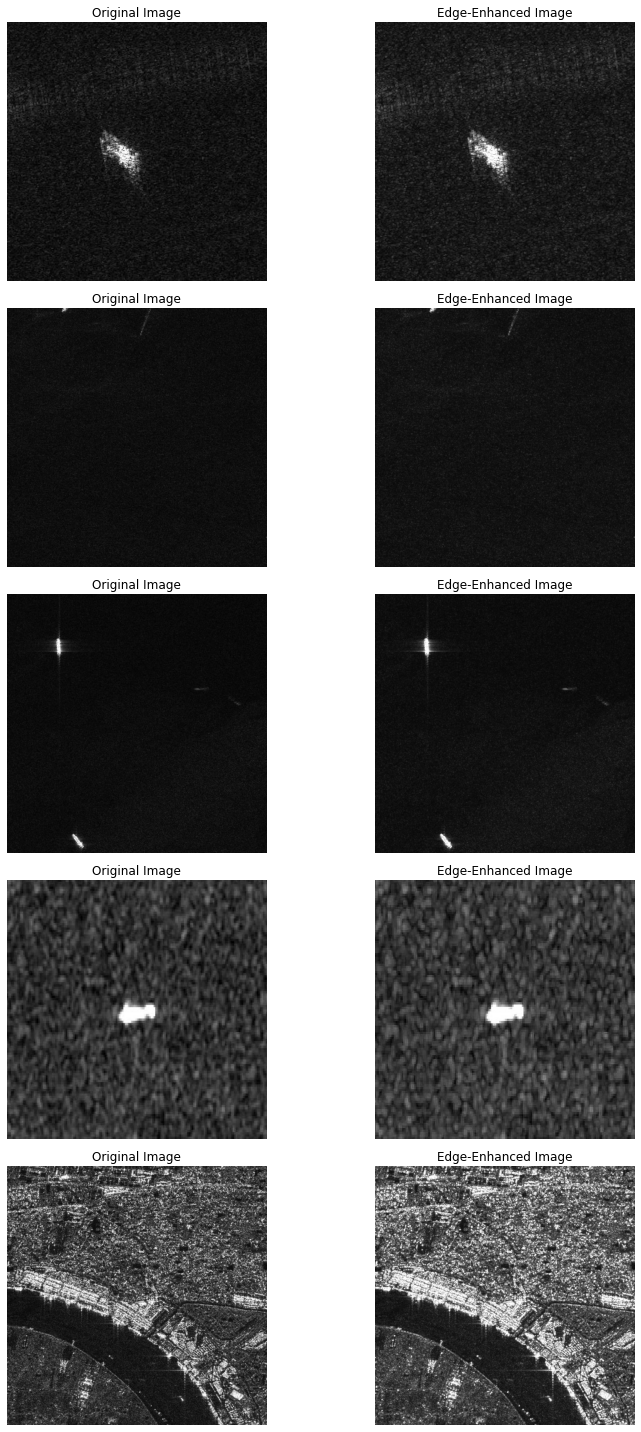

In [14]:
# Visualize a few examples
original_images = [os.path.join(original_dataset_dir, f) for f in os.listdir(original_dataset_dir) 
                  if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('_')]
enhanced_images = [os.path.join(edge_enhanced_dir, f) for f in os.listdir(edge_enhanced_dir) 
                  if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('_')]

if original_images and enhanced_images:
    # Sample a few images for visualization
    sample_indices = random.sample(range(min(len(original_images), len(enhanced_images))), 
                                  min(5, len(original_images), len(enhanced_images)))
    
    # Create figure
    fig, axes = plt.subplots(len(sample_indices), 2, figsize=(12, 4 * len(sample_indices)))
    
    for i, idx in enumerate(sample_indices):
        # Show original image
        original_img = cv2.imread(original_images[idx])
        axes[i][0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        axes[i][0].set_title(f"Original Image")
        axes[i][0].axis('off')
        
        # Show edge-enhanced image
        enhanced_img = cv2.imread(enhanced_images[idx])
        axes[i][1].imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
        axes[i][1].set_title(f"Edge-Enhanced Image")
        axes[i][1].axis('off')
    
    plt.tight_layout()
    plt.savefig('original_vs_enhanced.png', dpi=300)
    plt.show()

In [15]:
# Prepare YOLOv5 format dataset from the enhanced images
coco_json_path = os.path.join(edge_enhanced_dir, '_annotations.coco.json')
prepare_yolov5_dataset(coco_json_path, edge_enhanced_dir, yolov5_dataset_dir)

YOLOv5 dataset prepared at ./yolov5_dataset


'./yolov5_dataset'

## Models

In [16]:
def train_yolov5_with_edge_detection(dataset_yaml, weights='yolov5s.pt', epochs=10, 
                                    batch_size=16, img_size=640):
    """
    Train YOLOv5 model with edge-enhanced images
    
    Args:
        dataset_yaml: Path to dataset.yaml file
        weights: Initial weights (pre-trained model)
        epochs: Number of training epochs
        batch_size: Batch size
        img_size: Input image size
    """
    if not os.path.exists('yolov5'):
        os.system('git clone https://github.com/ultralytics/yolov5')
        
    os.system('pip install -r yolov5/requirements.txt')
    
    # Run training
    train_cmd = (
        f"cd yolov5 && "
        f"python train.py "
        f"--data {os.path.abspath(dataset_yaml)} "
        f"--weights {weights} "
        f"--epochs {epochs} "
        f"--batch-size {batch_size} "
        f"--img {img_size} "
        f"--name edge_enhanced"
    )
    
    print("Starting YOLOv5 training with the following command:")
    print(train_cmd)
    os.system(train_cmd)
    
    return os.path.join('yolov5', 'runs', 'train', 'edge_enhanced')

In [17]:
enhabnced_training_output = train_yolov5_with_edge_detection(
    os.path.join(yolov5_dataset_dir, 'dataset.yaml'), 
    weights='yolov5s.pt',
    epochs=10 
)

Cloning into 'yolov5'...


Defaulting to user installation because normal site-packages is not writeable
Starting YOLOv5 training with the following command:
cd yolov5 && python train.py --data /home/ubuntu/yolov5_dataset/dataset.yaml --weights yolov5s.pt --epochs 10 --batch-size 16 --img 640 --name edge_enhanced


2025-04-30 12:57:44.089371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746017864.210292    3172 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746017864.287181    3172 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/home/ubuntu/yolov5_dataset/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, proje

In [22]:
def train_yolov5_on_raw_images(original_dataset_dir, weights='yolov5s.pt', epochs=100, 
                              batch_size=16, img_size=640):
    """
    Train YOLOv5 model on original images without edge enhancement
    
    Args:
        original_dataset_dir: Directory containing the original dataset
        weights: Initial weights (pre-trained model)
        epochs: Number of training epochs
        batch_size: Batch size
        img_size: Input image size
    """
    # Create a YOLOv5 format dataset from original images
    yolov5_raw_dataset_dir = './yolov5_raw_dataset'
    coco_json_path = os.path.join(original_dataset_dir, '_annotations.coco.json')
    
    if not os.path.exists(coco_json_path):
        print(f"Error: Annotation file not found at {coco_json_path}")
        return None
    
    prepare_yolov5_dataset(coco_json_path, original_dataset_dir, yolov5_raw_dataset_dir)
    
    # Verify dataset.yaml was created
    dataset_yaml_path = os.path.join(yolov5_raw_dataset_dir, 'dataset.yaml')
    if not os.path.exists(dataset_yaml_path):
        print(f"Error: dataset.yaml not created at {dataset_yaml_path}")
        return None
    
    if not os.path.exists('yolov5'):
        os.system('git clone https://github.com/ultralytics/yolov5')
        
    os.system('pip install -r yolov5/requirements.txt')
    
    absolute_yaml_path = os.path.abspath(dataset_yaml_path)
    print(f"Using dataset config at: {absolute_yaml_path}")
    
    train_cmd = (
        f"cd yolov5 && "
        f"python train.py "
        f"--data {absolute_yaml_path} "  # Use absolute path
        f"--weights {weights} "
        f"--epochs {epochs} "
        f"--batch-size {batch_size} "
        f"--img {img_size} "
        f"--name raw_images"
    )
    
    print("Starting YOLOv5 training on raw images with the following command:")
    print(train_cmd)
    os.system(train_cmd)
    
    return os.path.join('yolov5', 'runs', 'train', 'raw_images')

In [23]:
raw_training_output = train_yolov5_on_raw_images(
    original_dataset_dir,
    weights='yolov5s.pt',
    epochs=10
)

YOLOv5 dataset prepared at ./yolov5_raw_dataset
Defaulting to user installation because normal site-packages is not writeable
Using dataset config at: /home/ubuntu/yolov5_raw_dataset/dataset.yaml
Starting YOLOv5 training on raw images with the following command:
cd yolov5 && python train.py --data /home/ubuntu/yolov5_raw_dataset/dataset.yaml --weights yolov5s.pt --epochs 10 --batch-size 16 --img 640 --name raw_images


2025-04-30 13:09:16.212597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746018556.222167    3889 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746018556.226736    3889 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/home/ubuntu/yolov5_raw_dataset/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, p

In [40]:
def visualize_training_performance(raw_model_stats, enhanced_model_stats, output_dir='training_comparison', display_in_notebook=True):
    """
    Visualize and compare training performance between original and edge-enhanced models
    
    Args:
        raw_model_stats: Path to training stats CSV for the raw model 
                        (typically found in yolov5/runs/train/raw_images/results.csv)
        enhanced_model_stats: Path to training stats CSV for the edge-enhanced model
                             (typically found in yolov5/runs/train/edge_enhanced/results.csv)
        output_dir: Directory to save the visualization plots
        display_in_notebook: Whether to display the plots in the notebook
        
    Returns:
        Dictionary of figure objects if display_in_notebook=True, 
        otherwise path to saved figures
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load results from CSV files
    try:
        raw_results = pd.read_csv(raw_model_stats)
        enhanced_results = pd.read_csv(enhanced_model_stats)
    except FileNotFoundError as e:
        print(f"Error loading results: {e}")
        print("Make sure training has completed and results.csv files exist.")
        return None

    # Resolve epoch KeyError
    raw_results.columns = raw_results.columns.str.strip()
    enhanced_results.columns = enhanced_results.columns.str.strip()
    
    # Dictionary to store figures
    figures = {}
    
    # 1. Training Loss Plot
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    
    loss_metrics = ['train/box_loss', 'train/obj_loss', 'train/cls_loss']
    loss_labels = ['Box Loss', 'Objectness Loss', 'Classification Loss']
    
    for metric, label in zip(loss_metrics, loss_labels):
        if metric in raw_results.columns and metric in enhanced_results.columns:
            ax1.plot(raw_results['epoch'], raw_results[metric], 'o-', label=f'Raw - {label}')
            ax1.plot(enhanced_results['epoch'], enhanced_results[metric], 's--', label=f'Enhanced - {label}')
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss Value')
    ax1.set_title('Training Loss Comparison')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'loss_comparison.png'), dpi=300)
    figures['loss'] = fig1
    
    # 2. Validation Metrics Plot
    fig2, axs = plt.subplots(2, 2, figsize=(18, 12))
    axs = axs.flatten()
    
    val_metrics = [
        ('metrics/precision', 'Precision'),
        ('metrics/recall', 'Recall'), 
        ('metrics/mAP_0.5', 'mAP@0.5'),
        ('metrics/mAP_0.5:0.95', 'mAP@0.5:0.95')
    ]
    
    for i, (metric, title) in enumerate(val_metrics):
        if metric in raw_results.columns and metric in enhanced_results.columns:
            axs[i].plot(raw_results['epoch'], raw_results[metric], 'o-', label='Raw Model')
            axs[i].plot(enhanced_results['epoch'], enhanced_results[metric], 's--', label='Edge-Enhanced Model')
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel('Value')
            axs[i].set_title(title)
            axs[i].legend()
            axs[i].grid(True, linestyle='--', alpha=0.7)
    
    plt.suptitle('Validation Metrics Comparison', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'validation_metrics_comparison.png'), dpi=300)
    figures['validation'] = fig2
    
    # 3. Training Progress Overview - Combined plot
    fig3, ax3 = plt.subplots(figsize=(14, 8))
    
    # Plot training progress (total loss and mAP)
    if 'train/box_loss' in raw_results.columns and 'metrics/mAP_0.5' in raw_results.columns:
        raw_total_loss = raw_results['train/box_loss'] + raw_results.get('train/obj_loss', 0) + raw_results.get('train/cls_loss', 0)
        enhanced_total_loss = enhanced_results['train/box_loss'] + enhanced_results.get('train/obj_loss', 0) + enhanced_results.get('train/cls_loss', 0)
        
        ax3_twin = ax3.twinx()
        
        ax3.plot(raw_results['epoch'], raw_total_loss, 'o-', color='blue', label='Raw - Total Loss')
        ax3.plot(enhanced_results['epoch'], enhanced_total_loss, 's--', color='green', label='Enhanced - Total Loss')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Loss Value', color='blue')
        ax3.tick_params(axis='y', labelcolor='blue')
        
        ax3_twin.plot(raw_results['epoch'], raw_results['metrics/mAP_0.5'], 'o-', color='red', label='Raw - mAP@0.5')
        ax3_twin.plot(enhanced_results['epoch'], enhanced_results['metrics/mAP_0.5'], 's--', color='purple', label='Enhanced - mAP@0.5')
        ax3_twin.set_ylabel('mAP Value', color='red')
        ax3_twin.tick_params(axis='y', labelcolor='red')
        
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='center right')
        
    ax3.set_title('Training Progress Overview: Loss vs. mAP')
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_progress_overview.png'), dpi=300)
    figures['overview'] = fig3
    
    print(f"Training performance visualizations saved to {output_dir}")
    
    # Close figures if not displaying in notebook
    if not display_in_notebook:
        for fig in figures.values():
            plt.close(fig)
        return output_dir
    
    return figures

Training performance visualizations saved to training_comparison


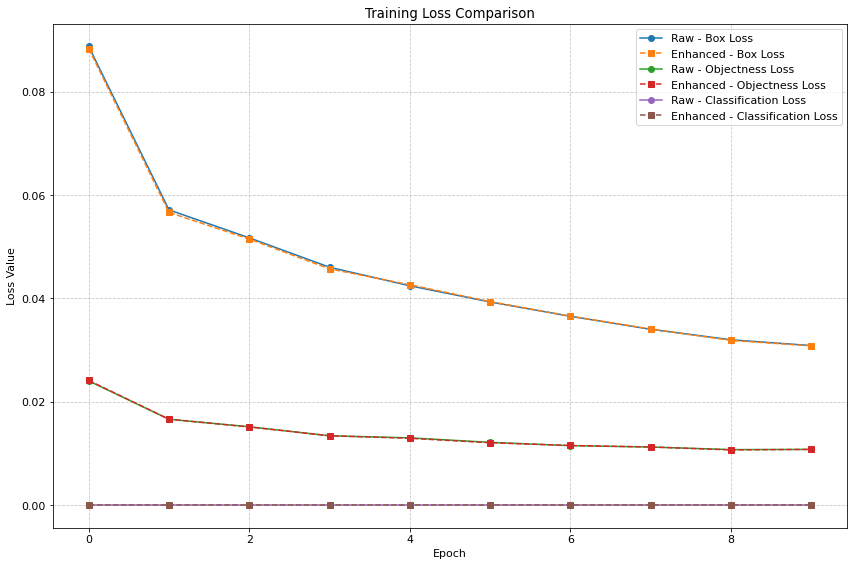

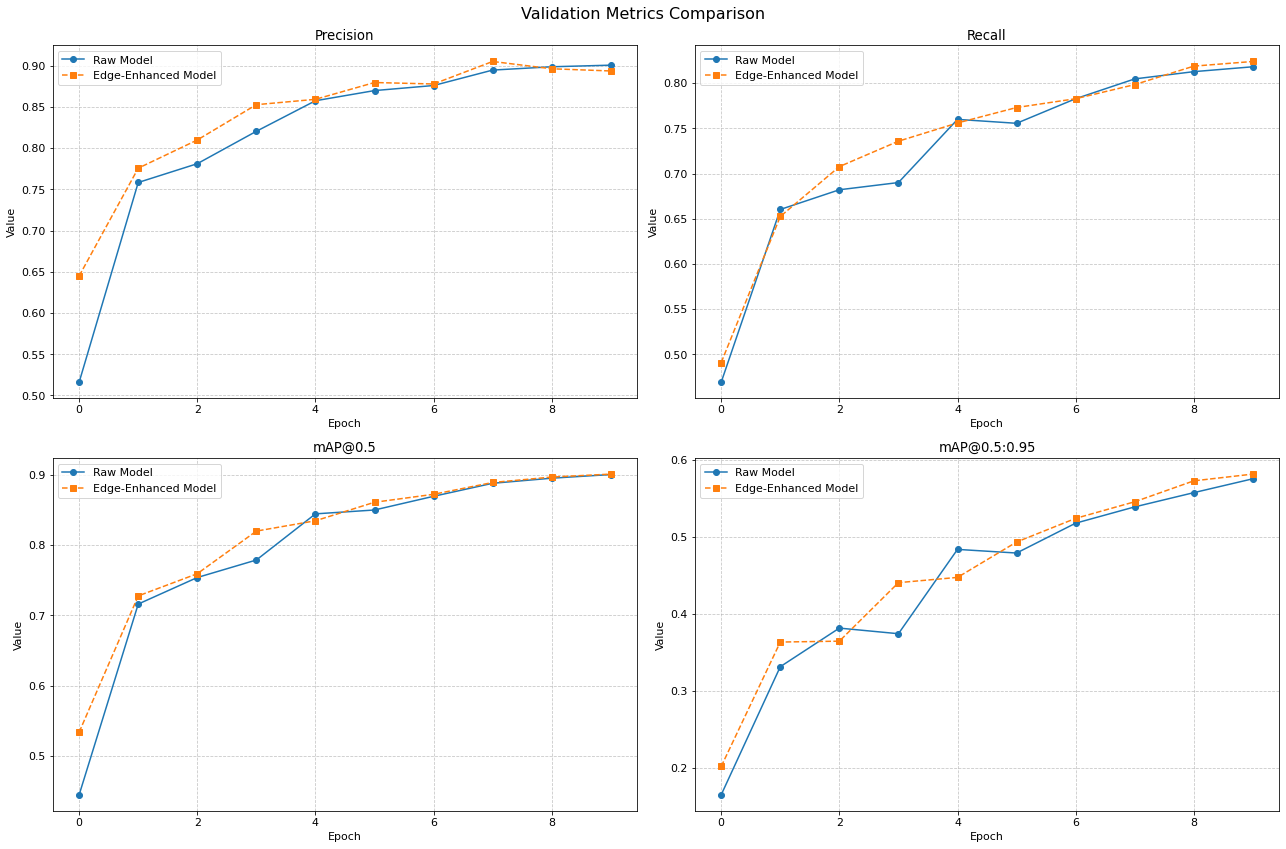

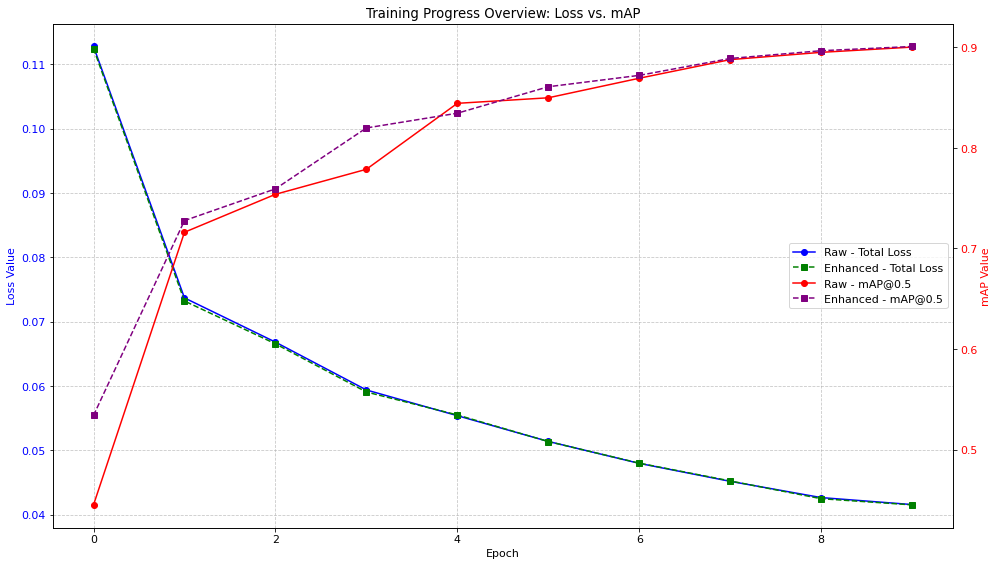

In [41]:
# Paths to the results.csv files from YOLOv5 training
raw_stats_path = './yolov5/runs/train/raw_images/results.csv'
enhanced_stats_path = './yolov5/runs/train/edge_enhanced/results.csv'

# Generate and display the visualizations
figures = visualize_training_performance(
    raw_stats_path,
    enhanced_stats_path,
    output_dir='training_comparison',
    display_in_notebook=True
)

if figures:
    loss_figure = figures['loss']
    validation_figure = figures['validation']
    overview_figure = figures['overview']

## Evaluate

In [27]:
def evaluate_yolov5_model(weights, dataset_yaml, img_size=640):
    """
    Evaluate YOLOv5 model on the test dataset
    
    Args:
        weights: Path to trained weights
        dataset_yaml: Path to dataset.yaml file
        img_size: Input image size
    """
    # Run validation
    val_cmd = (
        f"cd yolov5 && "
        f"python val.py "
        f"--data {os.path.abspath(dataset_yaml)} "
        f"--weights {weights} "
        f"--img {img_size} "
        f"--name edge_enhanced_val"
    )
    
    print("Starting YOLOv5 validation with the following command:")
    print(val_cmd)
    os.system(val_cmd)
    
    return os.path.join('yolov5', 'runs', 'val', 'edge_enhanced_val')

In [30]:
enhanced_eval = evaluate_yolov5_model(
    'runs/train/edge_enhanced/weights/best.pt',
    os.path.join('./yolov5_dataset', 'dataset.yaml')
)

Starting YOLOv5 validation with the following command:
cd yolov5 && python val.py --data /home/ubuntu/yolov5_dataset/dataset.yaml --weights runs/train/edge_enhanced/weights/best.pt --img 640 --name edge_enhanced_val


val: data=/home/ubuntu/yolov5_dataset/dataset.yaml, weights=['runs/train/edge_enhanced/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=edge_enhanced_val, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.10.12 torch-2.6.0 CUDA:0 (NVIDIA GH200 480GB, 96768MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /home/ubuntu/yolov5_dataset/labels.cache... 4716 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4716/4716 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 148/148 [00:23<00:00,  6.36it/s]
                   all       4716      13640      0.893      0.825      0.902      0.583
Speed: 0.0ms pre-process, 0.5ms inference

In [31]:
raw_eval = evaluate_yolov5_model(
    'runs/train/raw_images/weights/best.pt',
    os.path.join('./yolov5_raw_dataset', 'dataset.yaml')
)

Starting YOLOv5 validation with the following command:
cd yolov5 && python val.py --data /home/ubuntu/yolov5_raw_dataset/dataset.yaml --weights runs/train/raw_images/weights/best.pt --img 640 --name edge_enhanced_val


val: data=/home/ubuntu/yolov5_raw_dataset/dataset.yaml, weights=['runs/train/raw_images/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=edge_enhanced_val, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.10.12 torch-2.6.0 CUDA:0 (NVIDIA GH200 480GB, 96768MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /home/ubuntu/yolov5_raw_dataset/labels.cache... 4716 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4716/4716 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 148/148 [00:22<00:00,  6.55it/s]
                   all       4716      13640      0.897       0.82        0.9      0.576
Speed: 0.0ms pre-process, 0.5ms infe

In [35]:
def visualize_prediction_comparison(original_model, edge_enhanced_model, test_images, num_samples=5, display_in_notebook=True):
    """
    Visualize and compare predictions from original and edge-enhanced models
    
    Args:
        original_model: Path to original model weights
        edge_enhanced_model: Path to edge-enhanced model weights
        test_images: Directory containing test images
        num_samples: Number of samples to visualize
        display_in_notebook: Whether to display the visualizations in the notebook
    """
    # Ensure YOLOv5 is available
    if not os.path.exists('yolov5'):
        os.system('git clone https://github.com/ultralytics/yolov5')
    
    original = torch.hub.load('ultralytics/yolov5', 'custom', path=original_model)
    enhanced = torch.hub.load('ultralytics/yolov5', 'custom', path=edge_enhanced_model)
    
    # Get sample images
    image_files = [f for f in os.listdir(test_images) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if len(image_files) > num_samples:
        sample_files = random.sample(image_files, num_samples)
    else:
        sample_files = image_files
    
    # Create output directory for comparison
    output_dir = 'prediction_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    all_figures = []
    
    # Process each sample
    for img_file in sample_files:
        img_path = os.path.join(test_images, img_file)
        
        # Get predictions from both models
        original_results = original(img_path)
        enhanced_results = enhanced(img_path)
        
        # Create figure for comparison
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        
        # Show original model predictions
        original_img = original_results.render()[0]
        axes[0].imshow(original_img[:, :, ::-1])  # Convert BGR to RGB
        axes[0].set_title('Original Model Predictions')
        axes[0].axis('off')
        
        # Show edge-enhanced model predictions
        enhanced_img = enhanced_results.render()[0]
        axes[1].imshow(enhanced_img[:, :, ::-1])  # Convert BGR to RGB
        axes[1].set_title('Edge-Enhanced Model Predictions')
        axes[1].axis('off')
        
        plt.suptitle(f"Comparison for {img_file}", fontsize=16)
        
        # Save figure
        plt.tight_layout()
        save_path = os.path.join(output_dir, f"compare_{img_file}")
        plt.savefig(save_path, dpi=300)
        
        if display_in_notebook:
            all_figures.append(fig)
        else:
            plt.close(fig)
    
    print(f"Prediction comparisons saved to {output_dir}")
    
    if display_in_notebook:
        return all_figures
    else:
        return output_dir

Using cache found in /home/ubuntu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-4-30 Python-3.10.12 torch-2.6.0 CUDA:0 (NVIDIA GH200 480GB, 96768MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Using cache found in /home/ubuntu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-4-30 Python-3.10.12 torch-2.6.0 CUDA:0 (NVIDIA GH200 480GB, 96768MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/home/ubuntu/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/ubuntu/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(a

Prediction comparisons saved to prediction_comparison


[<Figure size 1440x720 with 2 Axes>,
 <Figure size 1440x720 with 2 Axes>,
 <Figure size 1440x720 with 2 Axes>,
 <Figure size 1440x720 with 2 Axes>,
 <Figure size 1440x720 with 2 Axes>]

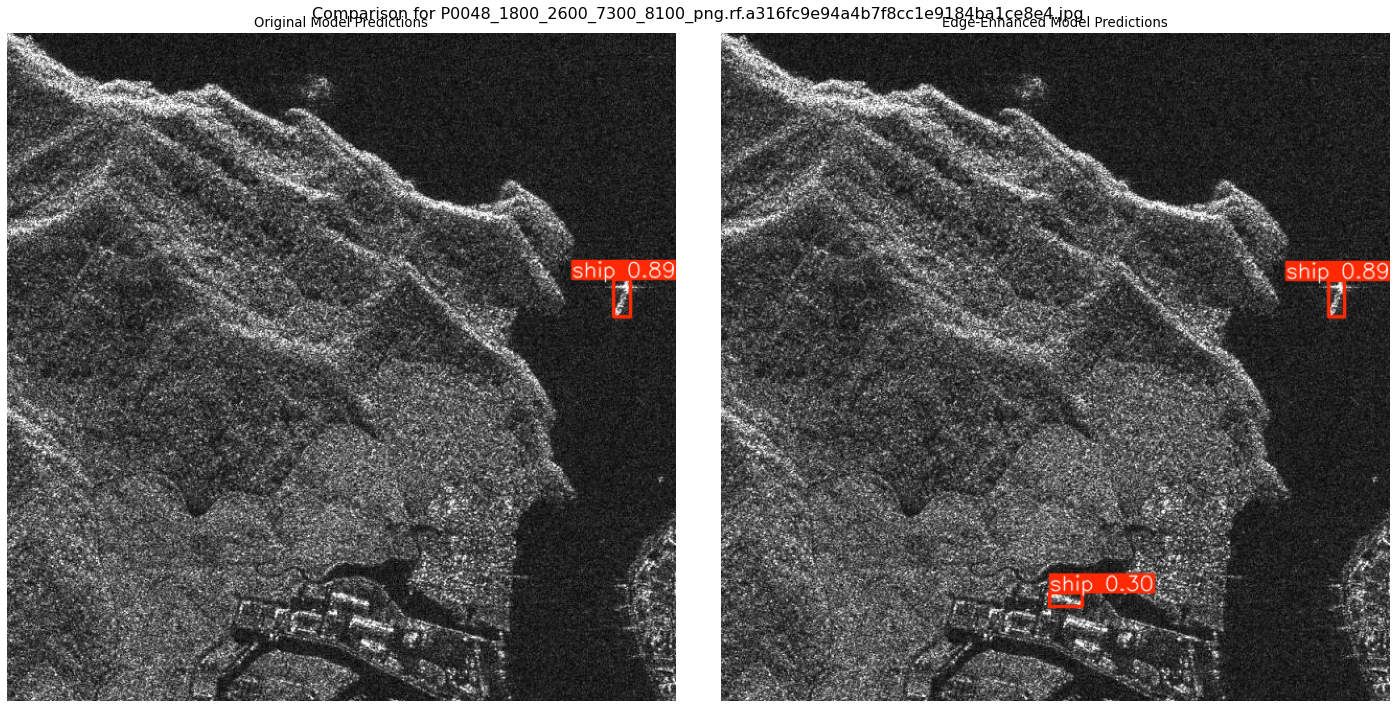

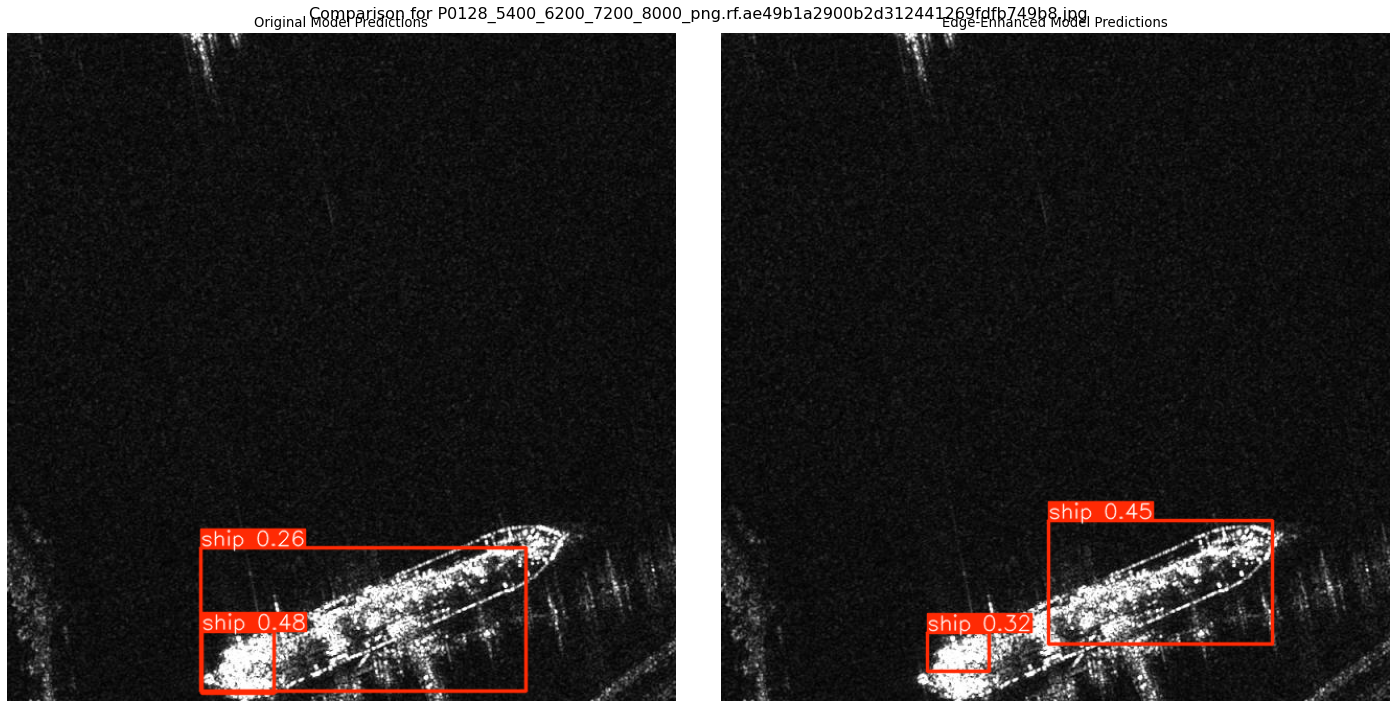

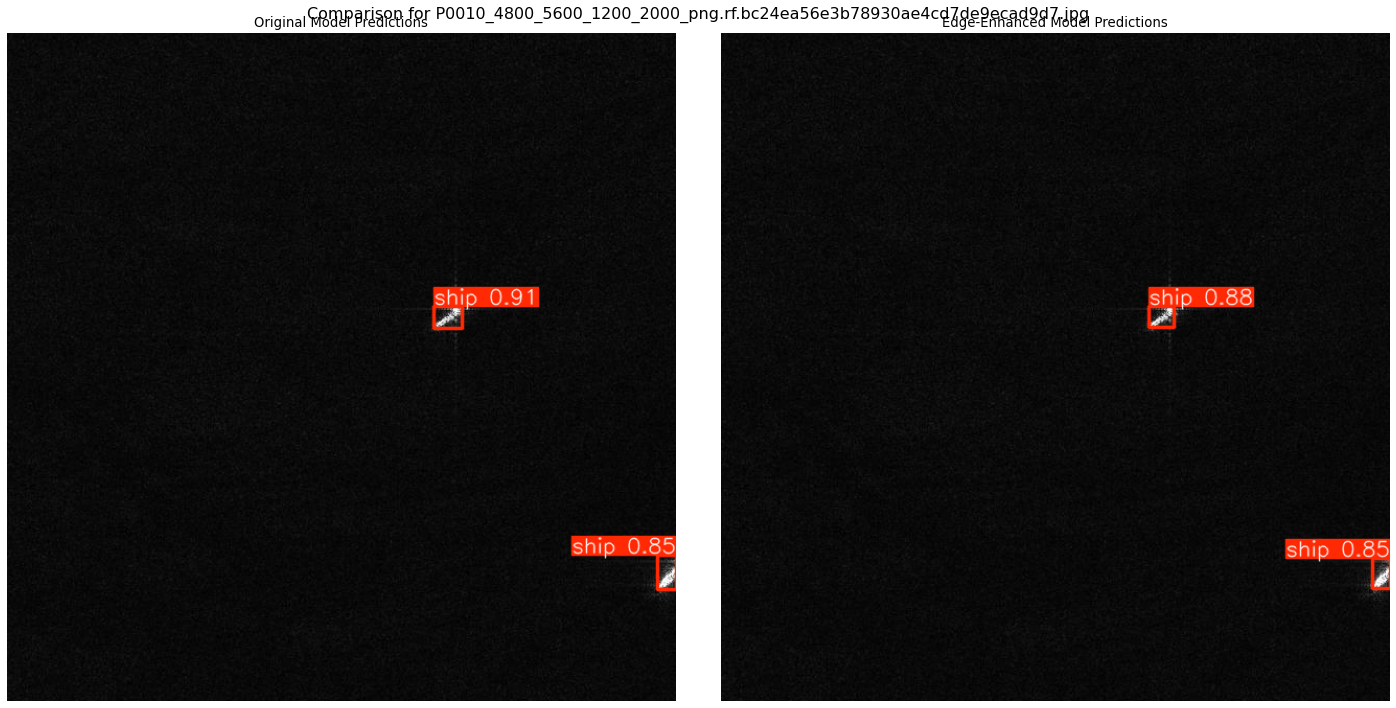

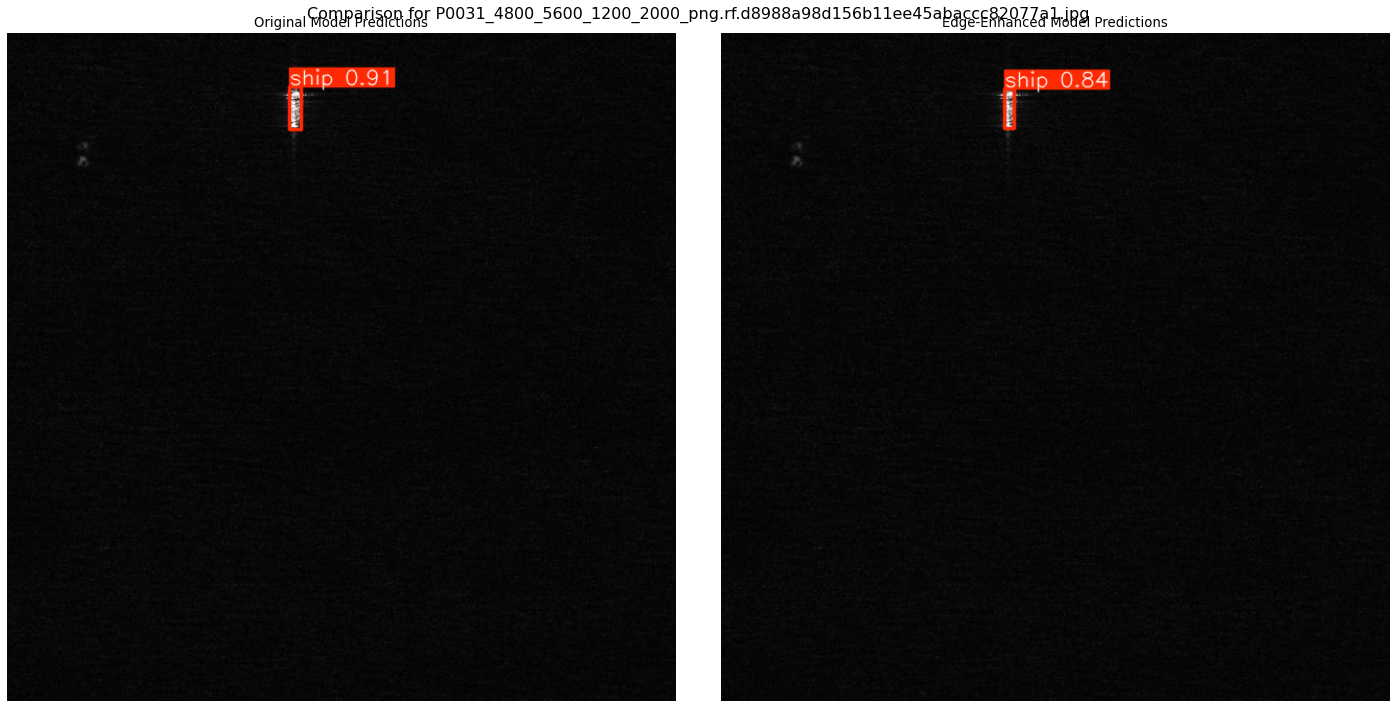

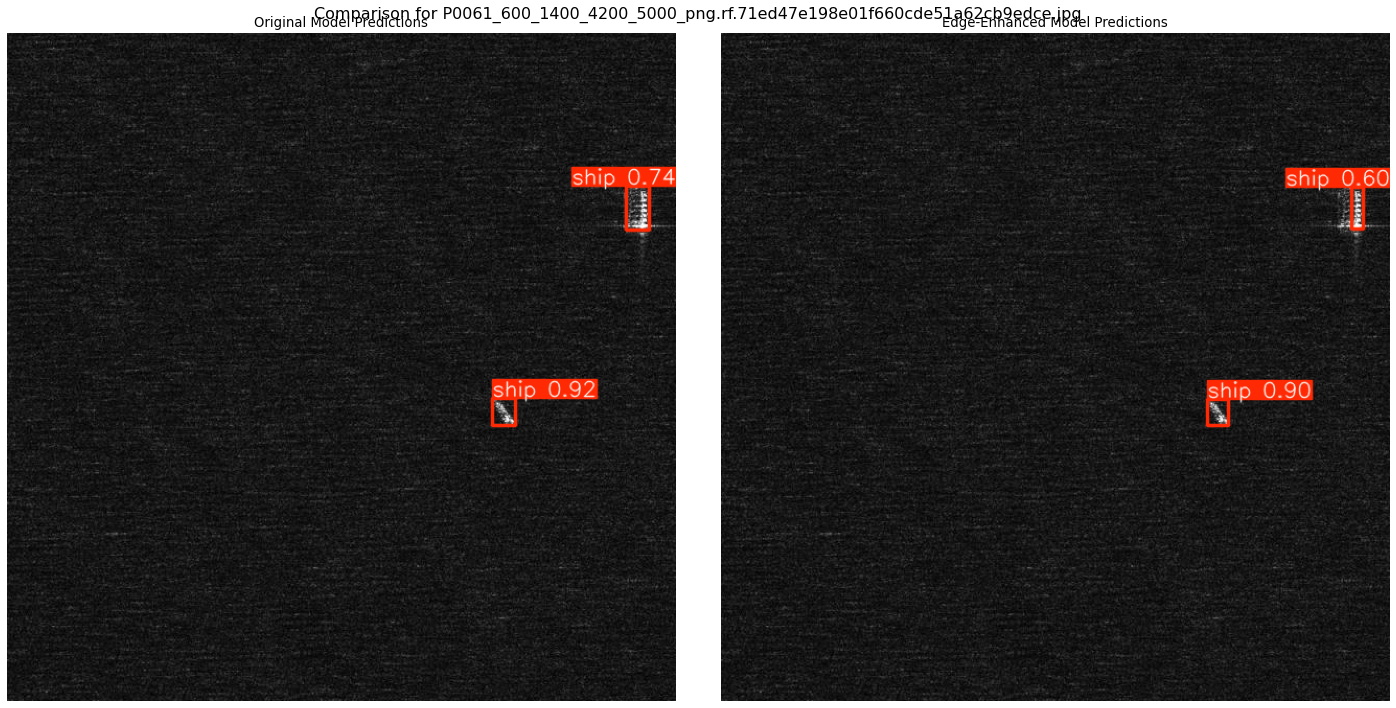

In [36]:
visualize_prediction_comparison(
    os.path.join(raw_training_output, 'weights/best.pt'),
    os.path.join(enhabnced_training_output, 'weights/best.pt'),
    './SARscope/test',
    num_samples=5,
    display_in_notebook=True
)